# MOSE 3×5 Optimization

This notebook optimizes a three-variable MOSE design against five stakeholder objectives.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

In [2]:
# Stakeholder weights (equal weighting by default)
w_initial = 0.2
w_maintenance = 0.2
w_sight = 0.2
w_access = 0.2
w_water = 0.2

weights = [w_initial, w_maintenance, w_sight, w_access, w_water]

# Preference knot points (edit to match stakeholder data)
initial_cost_knots = [5.0e8, 1.0e9, 8.0e9]
initial_cost_pref = [100, 50, 0]

maintenance_cost_knots = [1.0e10, 5.0e11, 1.5e12]
maintenance_cost_pref = [100, 40, 0]

sight_knots = [0, 5, 10]
sight_pref = [0, 50, 100]

access_knots = [0, 5, 10]
access_pref = [0, 50, 100]

water_knots = [0, 5, 10]
water_pref = [0, 50, 100]

# Design variable bounds: x1 (m), x2 (-), x3 (-) — adjust if needed
bounds = [
    [0.0, 1600.0],  # x1
    [1.0, 10.0],    # x2
    [0.5, 5.0],     # x3
]

# Optional constraints placeholder: add callables if domain limits are required
constraints = []

In [3]:
def compute_initial_cost(x1, x2, x3):
    return x1 * (x2 ** 2 * 75000 + 150000 / x3) + (1600 - x1) * ((x2 ** 2) * 15000)


def compute_maintenance_cost(x1, x2, x3):
    component = x2 * 3.125 * (10 ** 3) + 1.24 * (10 ** 4) / (x3 ** 2)
    return x1 * component * (1600 - x1) * (x2 * 100)


def compute_sight(x1, x2, x3):
    raw = x1 / 1600 * 10 + (1600 - x1) / 1600 * 10 * 1 / x2
    return np.clip(raw, sight_knots[0], sight_knots[-1])


def compute_accessibility(x1, x2, x3):
    raw = x1 / 1600 * 10 - (10 / 7) * x3
    return np.clip(raw, access_knots[0], access_knots[-1])


def compute_water_quality(x1, x2, x3):
    raw = x1 / 1600 * 10 - (10 / 24) * x3
    return np.clip(raw, water_knots[0], water_knots[-1])


def preference_initial_cost(x1, x2, x3):
    costs = compute_initial_cost(x1, x2, x3)
    costs = np.clip(costs, initial_cost_knots[0], initial_cost_knots[-1])
    return pchip_interpolate(initial_cost_knots, initial_cost_pref, costs)


def preference_maintenance_cost(x1, x2, x3):
    costs = compute_maintenance_cost(x1, x2, x3)
    costs = np.clip(costs, maintenance_cost_knots[0], maintenance_cost_knots[-1])
    return pchip_interpolate(maintenance_cost_knots, maintenance_cost_pref, costs)


def preference_sight(x1, x2, x3):
    scores = compute_sight(x1, x2, x3)
    return pchip_interpolate(sight_knots, sight_pref, scores)


def preference_accessibility(x1, x2, x3):
    scores = compute_accessibility(x1, x2, x3)
    return pchip_interpolate(access_knots, access_pref, scores)


def preference_water_quality(x1, x2, x3):
    scores = compute_water_quality(x1, x2, x3)
    return pchip_interpolate(water_knots, water_pref, scores)


def objective(values):
    x1 = values[:, 0]
    x2 = values[:, 1]
    x3 = values[:, 2]

    pref_initial = preference_initial_cost(x1, x2, x3)
    pref_maintenance = preference_maintenance_cost(x1, x2, x3)
    pref_sight = preference_sight(x1, x2, x3)
    pref_access = preference_accessibility(x1, x2, x3)
    pref_water = preference_water_quality(x1, x2, x3)

    return weights, [
        pref_initial,
        pref_maintenance,
        pref_sight,
        pref_access,
        pref_water,
    ]


Running GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            7.6339       19.4826          0            0.003        0           
1            4.5679       9.1755           0            0.086        0           
2            3.7946       6.4426           0            0.249        0           
3            3.1203       5.1823           0            0.254        0           
4            2.2768       4.4297           0            0.291        0           
5            2.2517       3.5459           0            0.298        0           
6            2.2517       3.5505           1            0.303        0           
7            2.2517       3.4669           2            0.312        0           
8            2.2517       2.9282           3            0.308        0           
9            2.2517       3.1292           4            0.309        0           
10           2.2

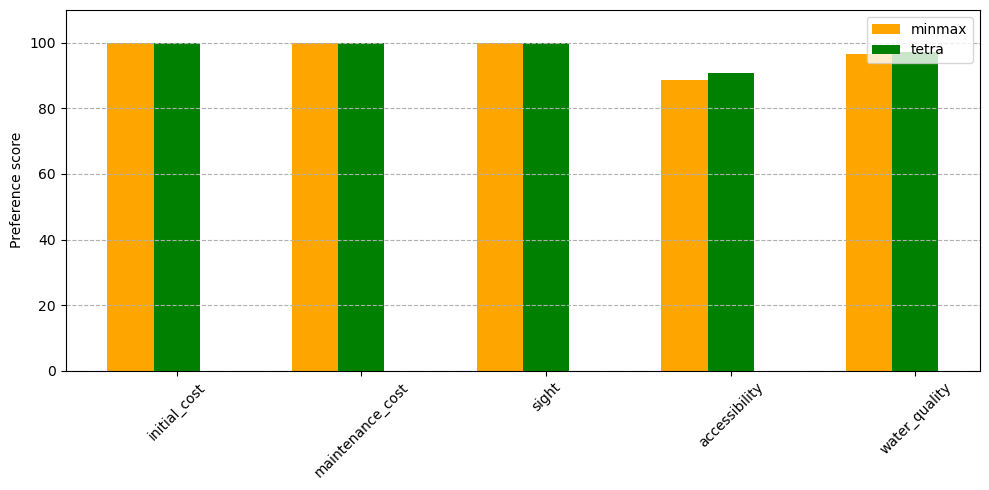

In [4]:
paradigms = ['minmax', 'tetra']
markers = ['o', '*', 's']
colours = ['orange', 'green', 'blue']

history = []

for idx, paradigm in enumerate(paradigms):
    options = {
        'n_bits': 10,
        'n_iter': 500,
        'n_pop': 600,
        'r_cross': 0.8,
        'max_stall': 10,
        'aggregation': paradigm,
        'var_type': 'real'
    }

    print(f'Running GA with {paradigm}')
    ga = GeneticAlgorithm(objective=objective, constraints=constraints, bounds=bounds, options=options)
    score, design_variables, _ = ga.run()

    x1_opt, x2_opt, x3_opt = design_variables

    metrics = {
        'initial_cost': compute_initial_cost(x1_opt, x2_opt, x3_opt),
        'maintenance_cost': compute_maintenance_cost(x1_opt, x2_opt, x3_opt),
        'sight': compute_sight(x1_opt, x2_opt, x3_opt),
        'accessibility': compute_accessibility(x1_opt, x2_opt, x3_opt),
        'water_quality': compute_water_quality(x1_opt, x2_opt, x3_opt),
    }

    preferences = {
        'initial_cost': float(preference_initial_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'maintenance_cost': float(preference_maintenance_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'sight': float(preference_sight(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'accessibility': float(preference_accessibility(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'water_quality': float(preference_water_quality(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
    }

    history.append({
        'paradigm': paradigm,
        'design': (x1_opt, x2_opt, x3_opt),
        'metrics': metrics,
        'preferences': preferences,
    })

    print(f"Optimal design for {paradigm}:")
    print(f"  x1 = {x1_opt:.2f}")
    print(f"  x2 = {x2_opt:.2f}")
    print(f"  x3 = {x3_opt:.2f}")
    print('  Metrics:')
    for key, value in metrics.items():
        print(f"    {key}: {value:.3f}")
    print('  Preference scores:')
    for key, value in preferences.items():
        print(f"    {key}: {value:.2f}")
    print('-' * 60)

# Optional: bar plot comparison of preference scores
labels = list(history[0]['preferences'].keys()) if history else []
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
for i, record in enumerate(history):
    scores = [record['preferences'][label] for label in labels]
    ax.bar(x + i * width, scores, width, label=record['paradigm'], color=colours[i % len(colours)])

ax.set_xticks(x + width)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Preference score')
ax.set_ylim(0, 110)
ax.legend()
ax.grid(linestyle='--', axis='y')
fig.tight_layout()
plt.show()


In [5]:
# Summary of optimal design variables and key metrics
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

print('Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality')
print('-' * 120)
for record in history:
    x1_opt, x2_opt, x3_opt = record['design']
    metrics = record['metrics']
    print(f"{record['paradigm']:>8} | {x1_opt:7.2f} | {x2_opt:6.2f} | {x3_opt:6.2f} | "
          f"{metrics['initial_cost']:12.3e} | {metrics['maintenance_cost']:14.3e} | "
          f"{metrics['sight']:5.2f} | {metrics['accessibility']:12.2f} | {metrics['water_quality']:13.2f}")


Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality
------------------------------------------------------------------------------------------------------------------------
  minmax | 1598.44 |   1.17 |   0.78 |    4.702e+08 |      6.984e+09 | 10.00 |         8.87 |          9.66
   tetra | 1598.44 |   1.00 |   0.64 |    4.942e+08 |      8.327e+09 | 10.00 |         9.08 |          9.72


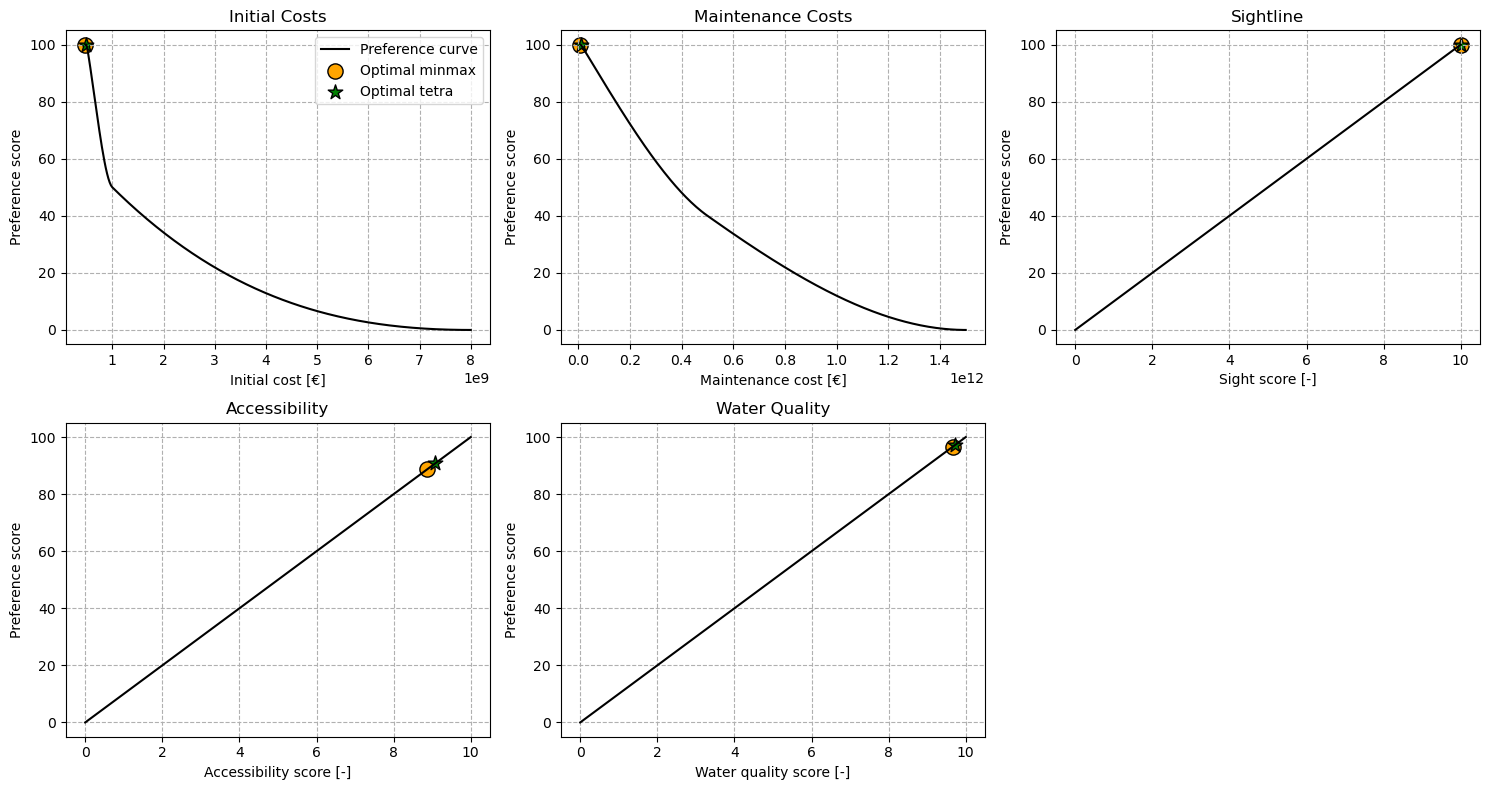

In [6]:
# Preference curves with GA solutions overlaid
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

objectives = [
    {
        'key': 'initial_cost',
        'title': 'Initial Costs',
        'knots_x': initial_cost_knots,
        'knots_y': initial_cost_pref,
        'compute': compute_initial_cost,
        'xlabel': 'Initial cost [€]'
    },
    {
        'key': 'maintenance_cost',
        'title': 'Maintenance Costs',
        'knots_x': maintenance_cost_knots,
        'knots_y': maintenance_cost_pref,
        'compute': compute_maintenance_cost,
        'xlabel': 'Maintenance cost [€]'
    },
    {
        'key': 'sight',
        'title': 'Sightline',
        'knots_x': sight_knots,
        'knots_y': sight_pref,
        'compute': compute_sight,
        'xlabel': 'Sight score [-]'
    },
    {
        'key': 'accessibility',
        'title': 'Accessibility',
        'knots_x': access_knots,
        'knots_y': access_pref,
        'compute': compute_accessibility,
        'xlabel': 'Accessibility score [-]'
    },
    {
        'key': 'water_quality',
        'title': 'Water Quality',
        'knots_x': water_knots,
        'knots_y': water_pref,
        'compute': compute_water_quality,
        'xlabel': 'Water quality score [-]'
    },
]

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for idx_obj, obj in enumerate(objectives):
    ax = axes[idx_obj]
    knots_x = np.array(obj['knots_x'], dtype=float)
    knots_y = np.array(obj['knots_y'], dtype=float)

    # gather GA results for this objective
    samples = [knots_x.min(), knots_x.max()]
    for record in history:
        x1_opt, x2_opt, x3_opt = record['design']
        samples.append(obj['compute'](x1_opt, x2_opt, x3_opt))

    x_min = min(samples)
    x_max = max(samples)
    if np.isclose(x_min, x_max):
        x_max = x_min + 1.0

    x_range = np.linspace(x_min, x_max, 300)

    # Clip into knot domain to avoid extrapolation beyond preference definition
    x_range_clipped = np.clip(x_range, knots_x.min(), knots_x.max())
    pref_curve = pchip_interpolate(knots_x, knots_y, x_range_clipped)

    ax.plot(x_range, pref_curve, color='black', label='Preference curve')

    for i, record in enumerate(history):
        x1_opt, x2_opt, x3_opt = record['design']
        metric_value = obj['compute'](x1_opt, x2_opt, x3_opt)
        pref_value = record['preferences'][obj['key']]
        ax.scatter(metric_value, pref_value, color=colours[i % len(colours)],
                   marker=markers[i % len(markers)], s=120, edgecolor='black',
                   label=f"Optimal {record['paradigm']}")

    ax.set_title(obj['title'])
    ax.set_xlabel(obj['xlabel'])
    ax.set_ylabel('Preference score')
    ax.set_ylim(-5, 105)
    ax.grid(linestyle='--')

    if idx_obj == 0:
        ax.legend()

# Hide the unused subplot if objectives < rows*cols
for j in range(len(objectives), len(axes)):
    axes[j].axis('off')

fig.tight_layout()
plt.show()
